## Introduction
This notebook features a function called create_graph which, when given the electoral code (known as the Serie in Uruguay) for a city or neighborhood and the departamento in which it is located, generates a visualization of the Frente Amplio (FA) vote share from 2004 through 2024 at each precinct in that area (this is sufficient to describe the electoral behavior, since currently most of the votes are casted either for the Frente Amplio or the parties in the Coalición Republicana). One key aspect of Uruguay’s voting system is that each voter’s identifying number remains the same over time. This allows us to track how the same individuals’ votes have evolved across multiple elections, offering a unique longitudinal perspective on shifts in electoral preferences.

Additionally, the graph helps identify “new voters”—those with an identifying number higher than the maximum used in the previous election. Observing how new voters cast their ballots can give insight into generational trends, especially since lower voter ID numbers are typically associated with older individuals. By analyzing these patterns, we can gain a better understanding of how voting behaviors and preferences change over time, as well as how different age cohorts might influence the broader electoral landscape.

In [1]:
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import TwoSlopeNorm

## Opening 2024 Results and Precints Data

In [3]:
padron=pd.read_csv('data/padron.csv')

In [4]:
file_path = "data/depto_circ_hojavot_nac_24_departamental.xlsx"

# Read the Excel file starting from row 9
df = pd.read_excel(file_path, header=8)  # header=8 means row 9 (0-based index) becomes column titlesartamental.xlsx')
df2=df[['CNT_VOTOS','CIRCUITO','SERIES','LEMA']].groupby(['CIRCUITO','SERIES','LEMA']).sum().reset_index().pivot(index=['CIRCUITO','SERIES'], columns='LEMA', values='CNT_VOTOS').reset_index().fillna(0)
# Define the list of columns for which to calculate relative sums
columns_to_normalize = [
    'Partido Asamblea Popular',
    'Partido Avanzar Republicano',
    'Partido Cabildo Abierto',
    'Partido Colorado',
    'Partido Constitucional Ambientalista',
    'Partido Ecologista Radical Intransigente',
    'Partido Frente Amplio',
    'Partido Identidad Soberana',
    'Partido Independiente',
    'Partido Nacional',
    'Partido Por Los Cambios Necesarios (PCN)'
]

# Calculate the row-wise sum of the specified columns
row_sums = df2[columns_to_normalize].sum(axis=1)

# Create new columns with relative sums by dividing each value by the row-wise sum
for col in ['Partido Frente Amplio']:
    df2['porc_fa_p_24'] = df2[col] / row_sums

In [5]:
def create_graph(serie,departamento):
    results_2024=df2[df2['SERIES']==serie][['CIRCUITO', 'porc_fa_p_24']]
    results_2024['year']=2024
    results_2024=results_2024.rename(columns={'CIRCUITO':'circuito'})

    filtered_padron = padron[padron['Serie'] == serie]
    # Initialize the merged dataset
    merged_results = filtered_padron

    # List of years to process
    years = [2004, 2009, 2014, 2019]
    result_data = {}

    # Iteratively merge porc_fa from the result files by year
    for year in years:
        # Construct the filename and read the CSV
        file_name = f'data/result_{year}.csv'
        df = pd.read_csv(file_name)
        result_data[year] = df  # Assign the full DataFrame to the dictionary
        print(f"Successfully loaded {file_name}. Columns: {df.columns.tolist()}")

        if 'depto' in df.columns:
            df=df[df['depto']==departamento]
        else:
            df=df[df['serie']==serie]

        df['year']=year

        # Filter the necessary columns and change format
        filtered_df = df[['circuito', 'porc_fa_p_'+str(year)[2:],'year']]
        merged_results[['Circuito', 'Desde', 'Hasta', 'year']] = merged_results[['Circuito', 'Desde', 'Hasta', 'year']].apply(pd.to_numeric, errors='coerce').astype(int)

        # Merge the filtered DataFrame with the merged_results DataFrame
        merged_results = pd.merge(
            merged_results,
            filtered_df,
            left_on=['Circuito', 'year'],
            right_on=['circuito', 'year'],
            how='left'
        )

        # Rename the porc_fa column to specify the year
        merged_results.drop(columns=['circuito'], inplace=True)


    # Filter the necessary columns
    filtered_df = results_2024

    # Merge the filtered DataFrame with the merged_results DataFrame
    merged_results = pd.merge(
        merged_results,
        filtered_df,
        left_on=['Circuito', 'year'],
        right_on=['circuito', 'year'],
        how='left'
    )

    # Rename the porc_fa column to specify the year
    merged_results.rename(columns={'porc_fa': f'porc_fa_{year}'}, inplace=True)
    merged_results.drop(columns=['circuito'], inplace=True)

    df=merged_results
    maximo=merged_results.iloc[-1,3]
    df = df.melt(
        id_vars=['Circuito', 'Serie', 'Desde', 'Hasta', 'year', 'depto'], 
        value_vars=['porc_fa_p_04', 'porc_fa_p_09', 'porc_fa_p_14', 'porc_fa_p_19', 'porc_fa_p_24'], 
        var_name='variable', 
        value_name='porc_FA'
    )

    # Filter rows with non-null `porc_FA`
    df = df.dropna(subset=['porc_FA'])

    # Map variable names to years
    df['year'] = df['variable'].str.extract('(\d{2})$').astype(int) + 2000

    # Define a colormap
    colors = [(0, "blue"), (0.5, "white"), (1, "red")]  # Positions: 0, 0.5, and 1
    cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)
    norm = mcolors.TwoSlopeNorm(vmin=df['porc_FA'].min()*100, vcenter=50, vmax=df['porc_FA'].max()*100)

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(12, 8))

    # Plot each rectangle
    grouped = df.groupby('year')
    for year, group in grouped:
        for _, row in group.iterrows():
            desde = row['Desde']
            hasta = row['Hasta']
            height = hasta - desde
            porc_fa = row['porc_FA']*100

            # Draw rectangle
            rect = patches.Rectangle(
                (year, desde),  # Bottom-left corner (x, y)
                width=1,  # Width of the rectangle
                height=height,  # Height of the rectangle
                color=cmap(norm(porc_fa)),  # Color based on porc_FA
                edgecolor="black"
            )
            ax.add_patch(rect)

    # Set axis labels and ticks
    ax.set_xlabel("Year", fontsize=12)
    ax.set_ylabel("Numero", fontsize=12)
    ax.set_xticks(range(2004, 2025, 5))  # Set x-axis from 2004 to 2019
    ax.set_yticks(range(0, df['Hasta'].max() + 1, 5000))  # Adjust the step if needed
    ax.set_xlim(2004, 2025)
    ax.set_ylim(0, maximo+1)

    # Add a colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, ax=ax, orientation="vertical", label="porc_FA (%)")

    # Show the plot
    plt.title("Porcentaje al FA en los últimos 20 años", fontsize=14)
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

Successfully loaded data/result_2004.csv. Columns: ['Unnamed: 0', 'depto', 'circuito', 'tot_partidos_04', 'porc_pi_p_04', 'porc_fa_p_04', 'porc_pc_p_04', 'porc_pn_p_04', 'porc_otros_04']
Successfully loaded data/result_2009.csv. Columns: ['Unnamed: 0', 'serie', 'circuito', 'tot_partidos_09', 'porc_pi_p_09', 'porc_fa_p_09', 'porc_pc_p_09', 'porc_pn_p_09', 'porc_ap_p_09']
Successfully loaded data/result_2014.csv. Columns: ['Unnamed: 0', 'serie', 'circuito', 'tot_partidos_14', 't_emitidos_14', 'porc_pi_p_14', 'porc_fa_p_14', 'porc_pc_p_14', 'porc_pn_p_14', 'porc_ap_p_14', 'porc_ap_p_14.1', 'porc_otros_p_14']
Successfully loaded data/result_2019.csv. Columns: ['Unnamed: 0', 'serie', 'circuito', 't_emitidos_19', 'tot_partidos_19', 'porc_pi_p_19', 'porc_fa_p_19', 'porc_pc_p_19', 'porc_pn_p_19', 'porc_ca_p_19', 'porc_otros_p_19', 'porc_ap_p_19']


C:\Users\guill\AppData\Local\Temp\ipykernel_3060\1339260734.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year']=year
C:\Users\guill\AppData\Local\Temp\ipykernel_3060\1339260734.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_results[['Circuito', 'Desde', 'Hasta', 'year']] = merged_results[['Circuito', 'Desde', 'Hasta', 'year']].apply(pd.to_numeric, errors='coerce').astype(int)
C:\Users\guill\AppData\Local\Temp\ipykernel_3060\1339260734.py:27: SettingWithCopyWarning: 
A value is tryin

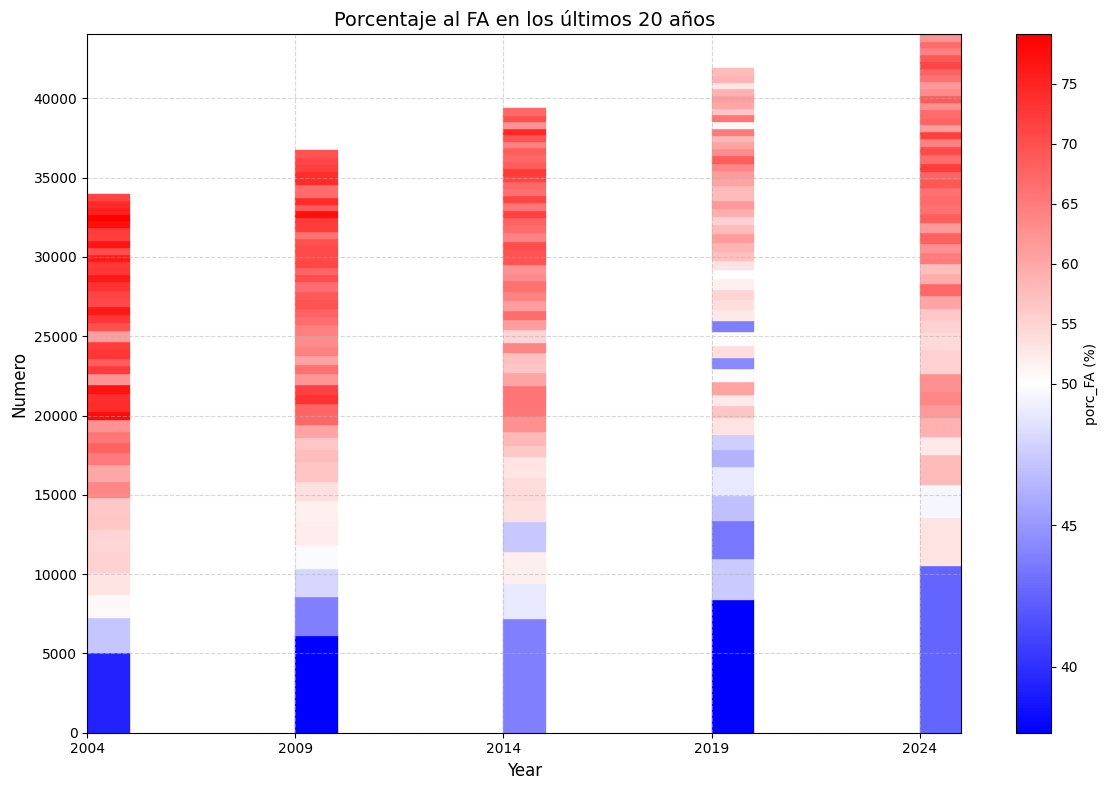

In [6]:
create_graph('CEA','Canelones')